**FEATURE ENGINEERING**

**IMPORTING LIBRARIES**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for standardizing the features
from sklearn.preprocessing import MinMaxScaler

from sklearn.impute import SimpleImputer

# mutual information analysis
from sklearn.feature_selection import mutual_info_classif

# for Principal Component Analysis
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [3]:
cleaned_df = pd.read_csv('cleaned_companies.csv')

**MUTUAL INFORMATION**

The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other.

In [4]:
X = cleaned_df.copy()
y = X.pop("status")

#Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

# label encoding for target variables
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [5]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y_encoded, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y_encoded, discrete_features)
mi_scores

active_days            0.298294
isClosed               0.298155
last_funding_at        0.047222
first_funding_at       0.044142
founded_at             0.035581
funding_rounds         0.021406
investment_rounds      0.019925
milestones             0.018979
relationships          0.018543
lat                    0.017972
first_milestone_at     0.017929
funding_total_usd      0.016993
lng                    0.016670
last_milestone_at      0.010836
category_code          0.008566
country_code           0.008502
last_investment_at     0.005234
first_investment_at    0.004942
Name: MI Scores, dtype: float64

**This indicates that the active_days has relatively high MI score which means it has a strong relation with the target variable.It suggests that changes in the "active_days" feature are informative about changes in the target variable. Similarly, 'investment_roounds' feature does not provide much information about the target variabl as other features.**

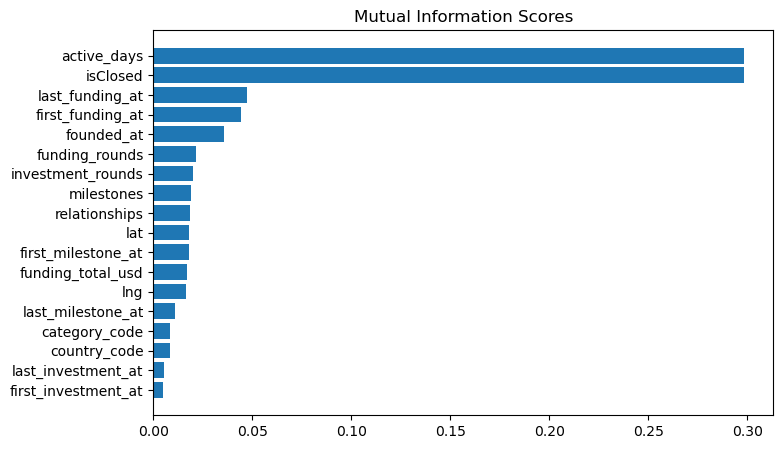

In [6]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

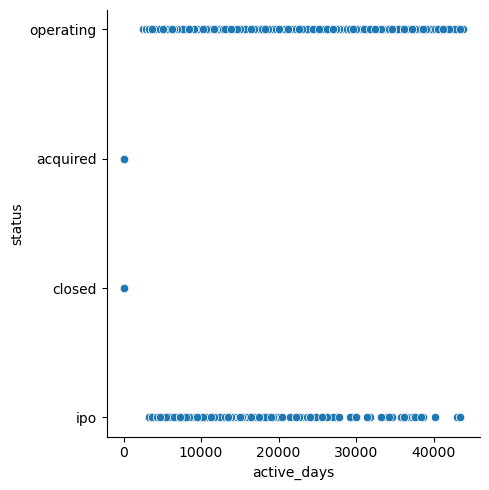

In [7]:
sns.relplot(x="active_days", y="status", data=cleaned_df);

**PRINCIPAL COMPONENT ANALYSIS (PCA)**

**Select the features that has comparatively high MI scores so that this approach might result in a more interpretable and potentially more predictive model**.

In [8]:
selected_features = ['active_days', 'isClosed','founded_at', 'last_funding_at', 'first_funding_at']

X = X.loc[:, selected_features]

In [9]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5
0,-0.090746,0.036163,-0.059721,-0.000502,0.000040
1,-0.089780,0.027553,-0.068243,-0.000216,0.000055
2,-0.089780,0.027553,-0.068243,-0.000216,0.000055
3,0.942073,-0.098245,0.078243,-0.024451,-0.007594
4,-0.089780,0.027553,-0.068243,-0.000216,0.000055


In [11]:
# Define the plot_variance function
def plot_variance(pca):
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(12, 6))
#Explained Variance
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, color='green', alpha=0.7)
    plt.title('Explained Variance by Principal Components')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.title('Cumulative Variance by Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)


    plt.subplots_adjust

In [12]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5
active_days,-0.134390,0.456270,0.476858,-0.739153,0.004022
isClosed,-0.985027,-0.127653,0.021137,0.113925,-0.001174
founded_at,-0.017394,-0.543226,-0.513909,-0.663679,0.005491
last_funding_at,-0.073626,0.477091,-0.489198,-0.003761,0.726384
first_funding_at,-0.077061,0.502803,-0.518403,-0.013798,-0.687254


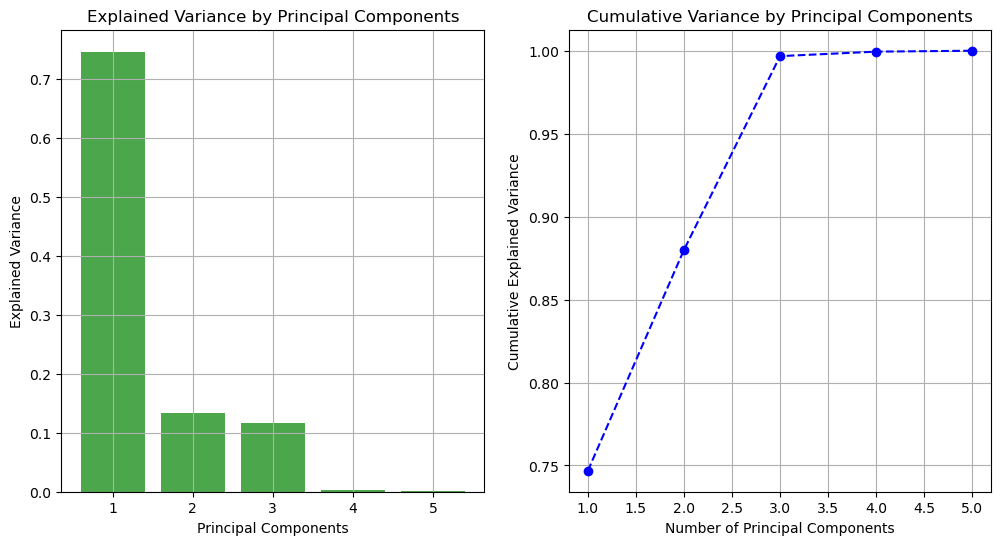

In [13]:
plot_variance(pca);

In [14]:
# Calculating the mi scores of principal components
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    0.309025
PC4    0.296055
PC3    0.286287
PC5    0.281303
PC2    0.277463
Name: MI Scores, dtype: float64